In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re



In [2]:
df = pd.read_csv("../enron_1.csv")

In [3]:
# 1. Check for NaNs in the processed text
num_nans = df['final_text'].isnull().sum()
print("NaNs in final_text:", num_nans)

# 2. Check for empty strings (after stripping whitespace)
num_empty = (df['final_text'].str.strip() == '').sum()
print("Empty strings in final_text:", num_empty)


NaNs in final_text: 1
Empty strings in final_text: 0


In [4]:
df = df.dropna(subset=['final_text']) # Drop rows that are NaN
df = df.reset_index(drop=True)


In [5]:
print(df.isnull().sum())


is_spam       0
final_text    0
dtype: int64


## Data Engineering/Extraction

### TF-IDF Vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,    # limit vocabulary size, 5000 features (these features are the most “important” words or n-grams from our corpus)
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words='english'  # skip common words
)

X_tfidf = tfidf.fit_transform(df['final_text'].fillna(''))
 #feature matrix, the numerical representation of all our documents


TF-IDF extracts each unique word (or n-gram), builds a vocabulary

Builds/returns a vocabulary of all unique words (or n-grams) it learned from your corpus. Above shows only the words that actually appear in the first email, along with their importance scores.

### Inspect / Analyze TF-IDF

In [7]:
vocab = tfidf.get_feature_names_out()
print(len(vocab))        # should be ≤ max_features
print(vocab[:20])        # preview first 20 words

5000
['00' '00 00' '00 10' '00 60' '00 90' '00 million' '00 pm' '000' '000 00'
 '000 000' '000 enron' '000 hpl' '000 mmbtu' '0000' '001' '01' '01 01'
 '01 2000' '01 2001' '01 enron']


In [8]:
# View words specifically 
word_vocab = [w for w in vocab if re.match(r'^[a-zA-Z]+$', w)]
print(f"Words only: {len(word_vocab)}")
print(word_vocab[:50])  # preview first 50 words


Words only: 3439
['aa', 'ab', 'ability', 'able', 'abroad', 'absence', 'absolutely', 'abuse', 'ac', 'academic', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accessory', 'accomplish', 'accordance', 'according', 'accordingly', 'account', 'accountant', 'accounting', 'accuracy', 'accurate', 'achieve', 'achievement', 'acquire', 'acquired', 'acquiring', 'acquisition', 'acre', 'acrobat', 'act', 'action', 'active', 'activity', 'actua', 'actual', 'actually', 'acy', 'ad', 'adam', 'add', 'added', 'adding', 'addition', 'additiona', 'additional', 'additionally']


Above checks TF-IDF vocabulary

In [9]:
i = 0  # first email
df_single = pd.DataFrame(X_tfidf[i].T.todense(), index=tfidf.get_feature_names_out(), columns=["tfidf"])
print(df_single[df_single.tfidf > 0]) #Filter to only non-zero TF-IDF scores


            tfidf
04       0.035158
05       0.071669
07       0.038055
08       0.036016
08 2000  0.058075
...           ...
update   0.038464
utility  0.091919
volume   0.037544
waiting  0.047460
working  0.035259

[149 rows x 1 columns]


In [10]:
sparsity = 1.0 - (X_tfidf.count_nonzero() / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 98.63%


Out of all the entries in your TF-IDF matrix, 98.62% are zeros.
Only 1.38% of the cells have a non-zero TF-IDF value.

### top words by TF-IDF score

In [11]:
# tfidf (TfidfVectorizer) and X_tfidf assumed present
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# average TF-IDF in spam vs non-spam
avg_spam = tfidf_df[df['is_spam'] == 1].mean(axis=0)
avg_nonspam = tfidf_df[df['is_spam'] == 0].mean(axis=0)

spam_top = avg_spam.sort_values(ascending=False).head(40)
print("Top TF-IDF words in spam (avg):")
print(spam_top)


Top TF-IDF words in spam (avg):
http           0.036147
com            0.033903
email          0.021875
www            0.020625
company        0.019221
click          0.018814
http www       0.017135
price          0.016159
software       0.015285
money          0.015048
offer          0.015029
free           0.014884
best           0.014865
site           0.014767
save           0.014642
time           0.014352
online         0.014208
want           0.013690
order          0.013216
info           0.013026
day            0.012880
new            0.012586
business       0.012561
information    0.012507
net            0.012393
like           0.012305
account        0.012030
000            0.011856
product        0.011829
mail           0.011767
need           0.011578
website        0.011016
life           0.010767
visit          0.010753
stop           0.010666
adobe          0.010446
make           0.010431
message        0.010377
hello          0.009895
viagra         0.009871
dtype: f

## Additional features (to test)

- Common keywords
- word count
- char count 
- Avg word length
- number frequency 
- punctuation frequency 

### Exploring common phishing keywords

In [12]:
key_words = [
    'click', 'login', 'transfer', 'free', 'win', 'payment', 'transaction', 'transfer', 'money', 'tax', 'receipt',
    'urgent', 'verify account', 'act', 'confirm', 'view', 'unusual', "limited", 
    "new", "message", "required", "action", "document", "verification","special", "offer"

]

# Dictionary to hold keyword summary
kw_summary = {}

# Loop through each keyword
for w in key_words:
    # Detect presence of keyword (boolean Series, not added to df)
    has_kw = df['final_text'].str.contains(r'\b' + re.escape(w) + r'\b', regex=True, case=False)
    
    # Compute metrics
    tp = ((has_kw) & (df['is_spam'] == 1)).sum()  # spam emails containing keyword
    fp = ((has_kw) & (df['is_spam'] == 0)).sum()  # non-spam emails containing keyword
    in_email = has_kw.sum()                       # total emails containing keyword

    # Store in summary
    kw_summary[w] = {
        'in_email': in_email,
        'spam_hits': tp,
        'nonspam_hits': fp,
        'spam_likelihood': tp / (in_email + 1e-9)
    }

# Convert to DataFrame for viewing
kw_df = pd.DataFrame.from_dict(kw_summary, orient='index').sort_values('spam_likelihood', ascending=False)
kw_df

spam_likelihood_dict = kw_df['spam_likelihood'].to_dict()

def keyword_likelihood_score(text):
    score = 0
    for kw, likelihood in spam_likelihood_dict.items():
        if re.search(r'\b' + re.escape(kw) + r'\b', text, flags=re.IGNORECASE):
            score += likelihood
    return score

# Add feature to DF
df['kw_score'] = df['final_text'].apply(keyword_likelihood_score)



In [13]:
df.sample(10)

,is_spam,final_text,kw_score
5674,0,"joe , fyi . please plan attending . schedule m...",0.347237
9882,1,issue interactive tv power ranking ! tivo : ne...,0.527687
27474,1,"whitman , continue - important - expected ( u ...",3.418835
24643,0,- - - - - original message - - - - - : jeffery...,0.332465
14584,1,"2 option , option 1 - put text want . option 2...",0.332465
10072,1,sending message communicated past business opp...,1.780449
16276,0,"reminder - interested attending either class ,...",0.666096
3868,1,"soto , \ _ 95 % 0 ff - vi - - g - ra , c - ia ...",0.000000
12900,0,", per drew ' request , forwarded information m...",0.521655
15242,1,dear friend know come surprise know . samiel o...,0.827532


In [14]:
df['word_count'] = df['final_text'].apply(lambda x: len(str(x).split()))
df['unique_word_count'] = df['final_text'].apply(lambda x: len(set(str(x).split())))

def count_numbers(text):
    return len(re.findall(r'\d+', text))

df['num_count'] = df['final_text'].apply(count_numbers)


import string
import re

def repeated_punct_symbols(text, min_repeat=2):
    text = str(text)
    # Define suspicious symbols (can adjust based on dataset)
    suspicious_chars = string.punctuation  # includes all standard punctuation
    # You could also customize like: "!$%#*?@"
    
    # Regex: any character in suspicious_chars repeated min_repeat or more times
    pattern = r'([{}])\1{{{}}}'.format(re.escape(suspicious_chars), min_repeat - 1)
    
    # Return 1 if any repeated pattern found, else 0
    return int(bool(re.search(pattern, text)))




In [15]:
df.sample(10)

,is_spam,final_text,kw_score,word_count,unique_word_count,num_count
12251,0,"louise , thank timeline . envisioned distribut...",1.055253,443,184,19
19668,1,"mr . janet omaha # 102 nelson mamdela ave , sa...",3.091317,345,210,18
18197,1,original replica rolex handwatches gentleman l...,0.732613,95,80,8
6888,0,hello ainsley : glad interested ! spoke vince ...,0.000000,162,98,15
14359,1,"hello , save 80 % che pcl sdi ly fact ! ali re...",0.000000,67,57,1
3602,1,totally awesome city city guide chic want meee...,0.610239,100,77,0
24667,0,' 1 hour team meeting tues 12 / 12 9 . audrey ...,0.000000,34,27,4
2901,0,cilco need pathed following way withdrawl day ...,0.000000,161,49,45
21381,0,- - - - - - - - - - - - - - - - - - - - - - fo...,0.000000,195,39,20
22695,1,train self - paced home study thousand people ...,2.495440,246,142,5


### Unsual/rare word feature 
- signal for unusual or suspicious words

In [16]:
from collections import Counter

all_words = " ".join(df['final_text']).split()  # Use your cleaned text column

# Count the frequency of each word
word_counts = Counter(all_words)

# Define and store rare words (appearing < n times across your entire corpus) 
rare_words = {w for w, c in word_counts.items() if c < 4}

# Function to count rare words per email
def count_rare_words(text):
    return sum(1 for w in str(text).split() if w in rare_words)

df['rare_word_count'] = df['final_text'].apply(count_rare_words)


In [17]:
df['num_urls'] = df['final_text'].str.count(r'http[s]?://')
df['num_emails'] = df['final_text'].str.count(r'\b[\w.-]+@[\w.-]+\.\w+\b')

threshold = 4
df['many_rare_words'] = (df['rare_word_count'] >= threshold).astype(int)


In [18]:
df.sample(10)

,is_spam,final_text,kw_score,word_count,unique_word_count,num_count,rare_word_count,num_urls,num_emails,many_rare_words
12344,0,mr . kitchen : attached margin number requeste...,0.679702,75,41,12,0,0,0,0
20896,0,"donna , attached report matrix paper & pulp . ...",0.000000,30,24,0,0,0,0,0
23973,1,* * * * * * * * * * * * * * * * * * * * * * * ...,3.561684,2709,778,252,1,0,0,0
24828,0,"michelle lokay , registered foursome , please ...",1.646588,682,339,46,58,0,0,1
22308,1,promote product service million today ! e - ma...,2.725730,161,90,6,1,0,0,0
24168,1,"need software pc ? visit site , might need . ....",0.000000,16,12,0,1,0,0,0
1997,0,sale deal # 714540 daren - look like meter sta...,0.000000,36,32,5,1,0,0,0
2997,0,"absence , bruce mcmills commercial defs contac...",0.000000,13,12,1,0,0,0,0
28570,1,international hiv / aid organization base spai...,2.507196,451,235,32,12,0,0,1
22503,1,dvd x copy platinum 4 . 0 . 38 - $ 19 . 95 htt...,0.458011,40,29,5,1,0,0,0


## Training

In [19]:
numeric_features = ['kw_score', 'word_count', 'unique_word_count','rare_word_count']
X_numeric = df[numeric_features]  # shape: (n_samples, n_numeric_features)

In [20]:
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MaxAbsScaler

# Convert numeric features to sparse
X_numeric_sparse = csr_matrix(X_numeric.values)

# Scale numeric features
scaler = MaxAbsScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_sparse)

# Combine TF-IDF (sparse) and numeric (now scaled & sparse)
X_combined = hstack([X_tfidf, X_numeric_scaled])

print(X_combined.shape)  # (n_samples, n_tfidf_features + n_numeric_features)


(29367, 5004)


## Logistic Regression

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

y = df['is_spam']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Logistic Regression
model = LogisticRegression(
    solver='saga', 
    max_iter=5000, 
    penalty='l2',
)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9805924412665986

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3095
           1       0.97      0.99      0.98      2779

    accuracy                           0.98      5874
   macro avg       0.98      0.98      0.98      5874
weighted avg       0.98      0.98      0.98      5874



In [22]:
train_set = accuracy_score(y_train, model.predict(X_train))
test_set = accuracy_score(y_test, model.predict(X_test))

print("Train accuracy:", train_set)
print("Test set acc:",  test_set)

Train accuracy: 0.9888903077512451
Test set acc: 0.9805924412665986


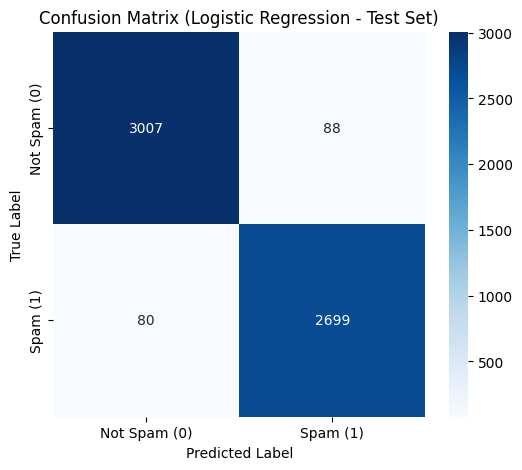

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spam (0)', 'Spam (1)'],  
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (Logistic Regression - Test Set)')     
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Cross-Validation Check

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_combined, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


Cross-validation accuracies: [0.9824651  0.98484848 0.98212157 0.98246211 0.98144049]
Mean accuracy: 0.9827 ± 0.0012


## Naive Bayes Model

In [35]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9713993871297242

Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3095
           1       0.97      0.97      0.97      2779

    accuracy                           0.97      5874
   macro avg       0.97      0.97      0.97      5874
weighted avg       0.97      0.97      0.97      5874



In [33]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(nb_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

Naive Bayes cross-val accuracies: [0.97139939 0.97361253 0.97309722 0.97360804 0.9720756 ]
Mean accuracy: 0.9728 ± 0.0009


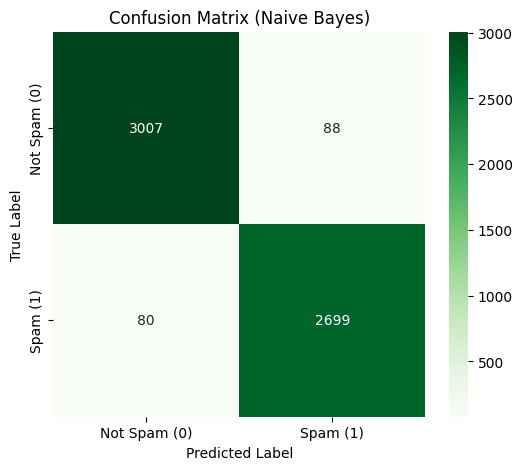

In [48]:
cm_nb = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Not Spam (0)', 'Spam (1)'],
    yticklabels=['Not Spam (0)', 'Spam (1)']
)
plt.title('Confusion Matrix (Naive Bayes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM Model

In [36]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9831460674157303

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      3095
           1       0.98      0.99      0.98      2779

    accuracy                           0.98      5874
   macro avg       0.98      0.98      0.98      5874
weighted avg       0.98      0.98      0.98      5874



In [46]:
train_set = accuracy_score(y_train, svm_model.predict(X_train))
test_set = accuracy_score(y_test, svm_model.predict(X_test))

print("Train accuracy:", train_set)
print("Test set acc:",  test_set)

Train accuracy: 0.9969778231813732
Test set acc: 0.9831460674157303


In [47]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_combined, y, cv=cv, scoring='accuracy')

print("SVM cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

SVM cross-val accuracies: [0.98433776 0.98501873 0.98450536 0.98365401 0.98365401]
Mean accuracy: 0.9842 ± 0.0005


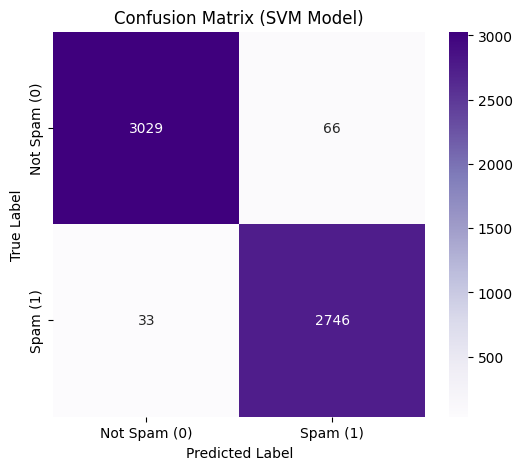

In [38]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()